<a href="https://colab.research.google.com/github/DRSNAJ/CNN-LSTM-RNN-image-description-generator/blob/main/news_sentiment_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
from datetime import datetime
import time
import plotly.express as px


In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/datasets/news_tweets')

['tweets_bbc.csv', 'tweets_cnn.csv', 'tweets_eco.csv']

In [ ]:
dataset_src = '/content/drive/MyDrive/Colab Notebooks/datasets/news_tweets'
news_df = pd.DataFrame()

datainfo = {"bbc":{"start_data":None,"end_data":None,"num_tweets":None},
            "cnn":{"start_data":None,"end_data":None,"num_tweets":None},
            "eco":{"start_data":None,"end_data":None,"num_tweets":None}}

all_outlets = ['bbc', 'cnn', 'eco']

for fileItem in os.listdir(dataset_src):
  data = pd.read_csv(dataset_src + "/" + fileItem)
  data['timestamp'] = pd.to_datetime((data['date'] + ' ' + data['time']))

  for i in all_outlets:
    data[i] = 0

  try:
    outlet = 'unknown'
    if (fileItem == 'tweets_bbc.csv'):
      outlet = "bbc"
    elif (fileItem == 'tweets_cnn.csv'):
      outlet = "cnn"
    elif (fileItem == 'tweets_eco.csv'):
      outlet = "eco"
    else:
      outlet = 'unknown'

    data[outlet] = 1

    datainfo[outlet]["start_data"] = data[data['timestamp'] == data['timestamp'].min()]['timestamp'].item()
    datainfo[outlet]["end_data"] = data[data['timestamp'] == data['timestamp'].max()]['timestamp'].item()
    datainfo[outlet]["num_tweets"] = data.shape[0]

  except Exception as e:
    print(f"File not found: {e}")


  news_df = pd.concat([news_df,data])
  news_df = news_df[['timestamp','bbc','cnn','eco','tweet']]

news_df['timestamp'] = news_df['timestamp'].round('min') # minute


# Regular expression pattern to match URLs
tweet_link_format = r'(\s)http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Replace URLs with an empty string
news_df['tweet'] = news_df['tweet'].str.replace(tweet_link_format, '', regex=True)
news_df['tweet'] = news_df['tweet'].str.replace('. Follow live updates:', '', regex=True)

# Printing results
total_tweets = 0
data_tbl = '\n==================================DATA SUMMARY===================================\n|Outlet \t|Start Date \t\t|End Date \t\t|Tweets \t|\n|---------------|-----------------------|-----------------------|---------------|\n'
for outlet in all_outlets:
  data_tbl = data_tbl + '|'+ outlet + '\t\t|'+ str(datainfo[outlet]["start_data"]) + '\t|'+ str(datainfo[outlet]["end_data"]) + '\t|'+ str(datainfo[outlet]["num_tweets"]) +'\t\t|\n'
  total_tweets = total_tweets + datainfo[outlet]["num_tweets"]
data_tbl = data_tbl +'|---------------|-----------------------|-----------------------|---------------|\n' + '|\t\t|\t\t\t|\t\t\t|' + str(total_tweets) + '\t\t|'
data_tbl = data_tbl +'\n=================================================================================\n'
print(data_tbl)

<ipython-input-17-b5797ba07313>:11: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_src + "/" + fileItem)
<ipython-input-17-b5797ba07313>:11: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_src + "/" + fileItem)
<ipython-input-17-b5797ba07313>:11: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_src + "/" + fileItem)
<ipython-input-17-b5797ba07313>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['timestamp'] = news_df['timestamp'].round('min') # minute



==================================DATA SUMMARY===================================
|Outlet 	|Start Date 		|End Date 		|Tweets 	|
|---------------|-----------------------|-----------------------|---------------|
|bbc		|2010-01-01 19:40:04	|2021-07-02 15:28:43	|34547		|
|cnn		|2010-01-01 06:58:23	|2021-07-05 05:08:12	|55236		|
|eco		|2010-01-01 21:20:14	|2021-07-05 04:59:39	|254413		|
|---------------|-----------------------|-----------------------|---------------|
|		|			|			|344196		|



In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/datasets/forex_data/DAT_MT_GBPUSD_M1'

forex_data = pd.DataFrame()
column_names = ['date','time','open','high','low','close','na']

for f in os.listdir(data_path):
  data = pd.read_csv(data_path + '/' + f, names=column_names)

  # Formatting data and creating timestamps
  data['date'] = data['date'].str.replace('.', '-')
  data['timestamp'] = pd.to_datetime((data['date'] + ' ' + data['time']))

  forex_data = pd.concat([forex_data,data])

# Removing duplicates and sorting by time.
forex_data = forex_data[['timestamp','close']].drop_duplicates().sort_values(by='timestamp')

# Adding in missing timestamps and interpolating the forex prices between those values.
forex_data = forex_data.set_index('timestamp')['close'].asfreq(freq='60s').interpolate()
forex_data = forex_data.to_frame()

# Smoothing out closing data over 4H to remove noise using Exponential Moving Average and Simple Moving Average
period = 60*4
forex_data['4hemw'] = forex_data['close'].ewm(span=period, adjust=False).mean() # Exponential Moving Average
forex_data['ma'] = forex_data['close'].rolling(window=period).mean() # Simple Moving Average

# Calculating the rate of change of the exponential moving average
forex_data['fxgrad'] = np.gradient(forex_data['4hemw'])
forex_data['fxgrad'] = forex_data['fxgrad'].rolling(window=period).mean() # can try ema here as well


In [ ]:
forex_data.columns

Index(['close', '4hemw', 'ma', 'fxgrad'], dtype='object')

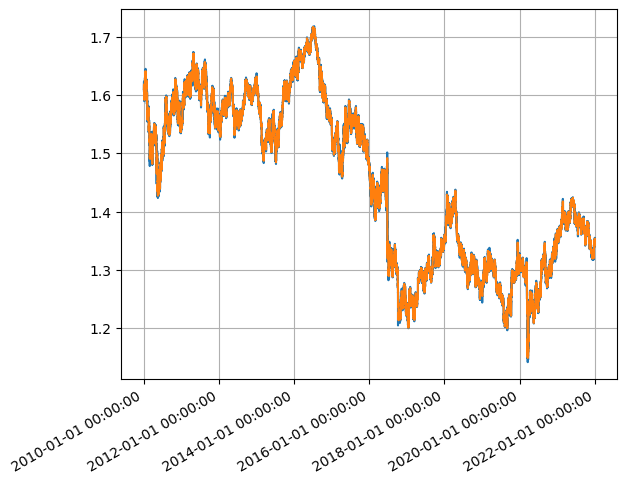

In [ ]:
date_rng = [datetime.strptime('2018/05/04', '%Y/%m/%d'), datetime.strptime('2018/05/07', '%Y/%m/%d')]
plt_data = forex_data[date_rng[0]:date_rng[1]]

ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)

plt.plot(forex_data.index, forex_data['close'])
plt.plot(forex_data.index, forex_data['4hemw'])
# plt.plot(forex_data.index, forex_data['fxgrad'])

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.grid(True)
plt.show()

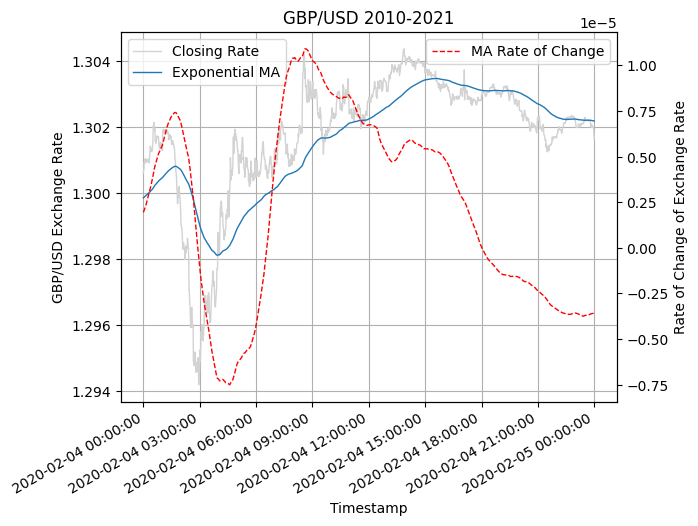

In [77]:
date_rng = [datetime.strptime('2020/02/04 00:00:00', '%Y/%m/%d %H:%M:%S'), datetime.strptime('2020/02/05 00:00:00', '%Y/%m/%d %H:%M:%S')]
plt_data = forex_data[date_rng[0]:date_rng[1]]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax1.xaxis.set_major_formatter(xfmt)
ax2.xaxis.set_major_formatter(xfmt)

ax1.plot(plt_data.index, plt_data['close'], linewidth=1, color='lightgray')
ax1.plot(plt_data.index, plt_data['4hemw'], linewidth=1)
ax2.plot(plt_data.index, plt_data['fxgrad'], 'r--', linewidth=1)

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.legend(['Closing Rate', 'Exponential MA'])
ax2.legend(['MA Rate of Change'])
ax1.grid(True)

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('GBP/USD Exchange Rate')
ax2.set_ylabel('Rate of Change of Exchange Rate')
ax1.set_title('GBP/USD 2010-2021')
plt.show()

In [83]:
result = pd.merge(news_df, forex_data, left_on='timestamp', right_index=True)
# result[(result['timestamp'] < date_rng[0]) & (result['timestamp'] > date_rng[1])]
# result[result['timestamp'] > datetime.strptime("2020-02-04 04:00:00", '%Y-%m-%d %H:%M:%S')]

# data labeles shoufl be 1 when risong 0 when nothing and -1 when falling so weight the values between these
abs(result['fxgrad']).min()

5.236551932815322e-16

(array([1.80000e+01, 1.10000e+01, 4.00000e+00, 8.00000e+00, 7.00000e+00,
        7.00000e+00, 6.70000e+02, 3.29158e+05, 1.42080e+04, 7.90000e+01]),
 array([-3.94761372e-04, -3.43775876e-04, -2.92790380e-04, -2.41804884e-04,
        -1.90819388e-04, -1.39833892e-04, -8.88483964e-05, -3.78629005e-05,
         1.31225955e-05,  6.41080915e-05,  1.15093587e-04]),
 <BarContainer object of 10 artists>)

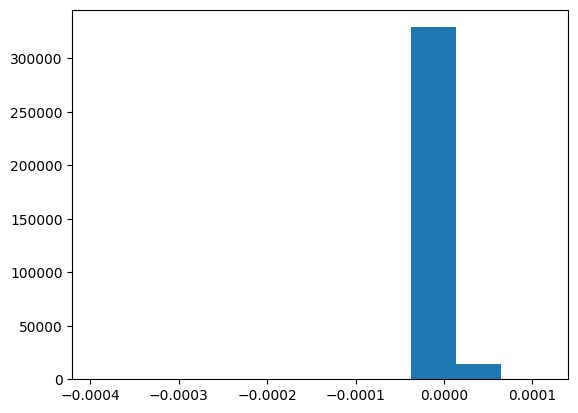

In [85]:
plt.hist(result['fxgrad'])